In [1]:
%load_ext autoreload
%autoreload 2

# Twitter Sentiment Analysis Project
<font size="4"> Author: Jeffrey Hanif Watson </font>

## Overview:

## Business Understanding:
Companies can benefit from understanding how consumers perceive their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner. A surge in negative sentiment would indicate a crisis of some sort that would need to be addressed quickly, and thus negative sentiment was deemed to be the most important class for modeling purposes in the project. However, data on the level of positive sentiment is still very valuable information, so a model that captures both sentiments as accurately as possible is most desirable.  

## Data Understanding:
The baseline data for this project consists of a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions) dataset. From the overwhelming amount of SXSW hashtags, and numerous references to the iPad 2 (which was released on March 2nd, 2011), it appears that the data was collected during the 2011 South by Southwest festival (which ran from March 11th to March 20th). The data contained ternary (positive, neutral, negative) sentiment data which was filtered down to binary (positive, negative) classes for modeling purposes. 

During the modeling process, the class imbalance in the data was shown to interfer with model performance, and additional negative sentiment data was used to augment the baseline data. 1,117 rows of negative general topic tweets were obtained from [Kaggle](https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets), and an additional 1,219 negative apple tweets were procured from [data.world](https://data.world/crowdflower/apple-twitter-sentiment). This data augmentation greatly improved model performance.

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [49]:
# imports
import os, sys

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import visualizations as v
from src import functions as f
from src import classes as c 

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
# GridSearchCV
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import RandomForestClassifier

# from imblearn.over_sampling import SMOTE, RandomOverSampler
# from imblearn.pipeline import Pipeline 

import pickle

# import matplotlib.pyplot as plt
# import seaborn as sns
# from wordcloud import WordCloud
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

## EDA

#### Importing the Baseline EDA Data

In [53]:
path = os.path.join(gparent, 'data/processed', 'baseline_data.csv')
df = pd.read_csv(path, encoding='unicode_escape')

## Class Balance of the Baseline Data

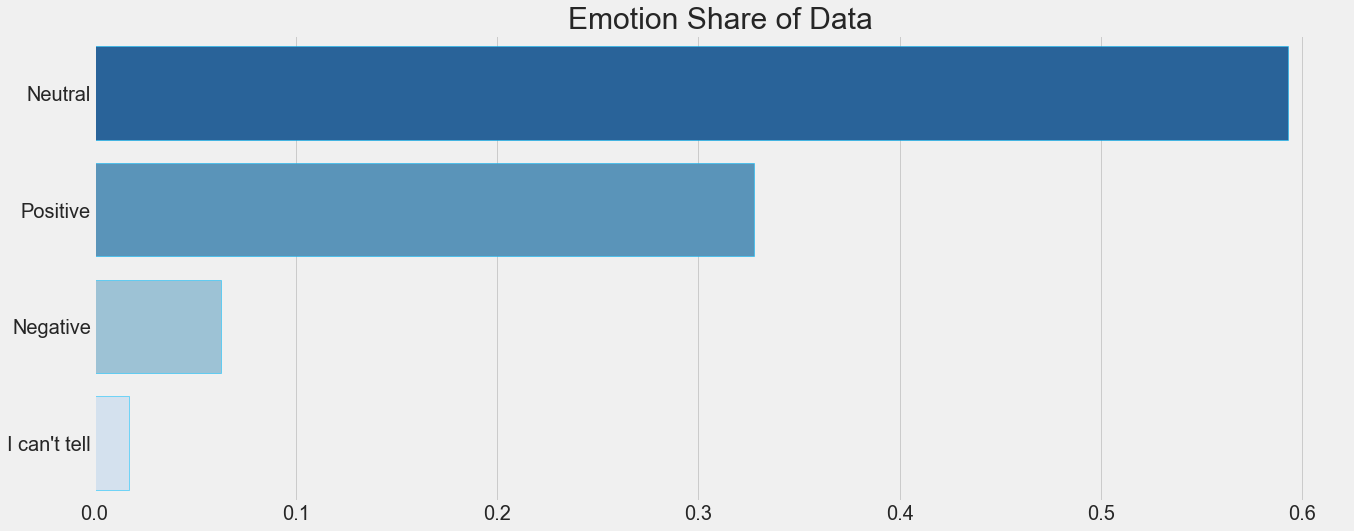

In [52]:
vz.emotion_freqs(df)

<font size="4">`No emotion` accounts for 59% of the data.</font>

<font size="4">`Positive emotion`                   accounts for 33% of the data.</font>

<font size="4">`Negative emotion`                   accounts for 6% of the data.</font>

<font size="4">`I can't tell`                       accounts for 2% of the data.</font>

## Emotions by Brand

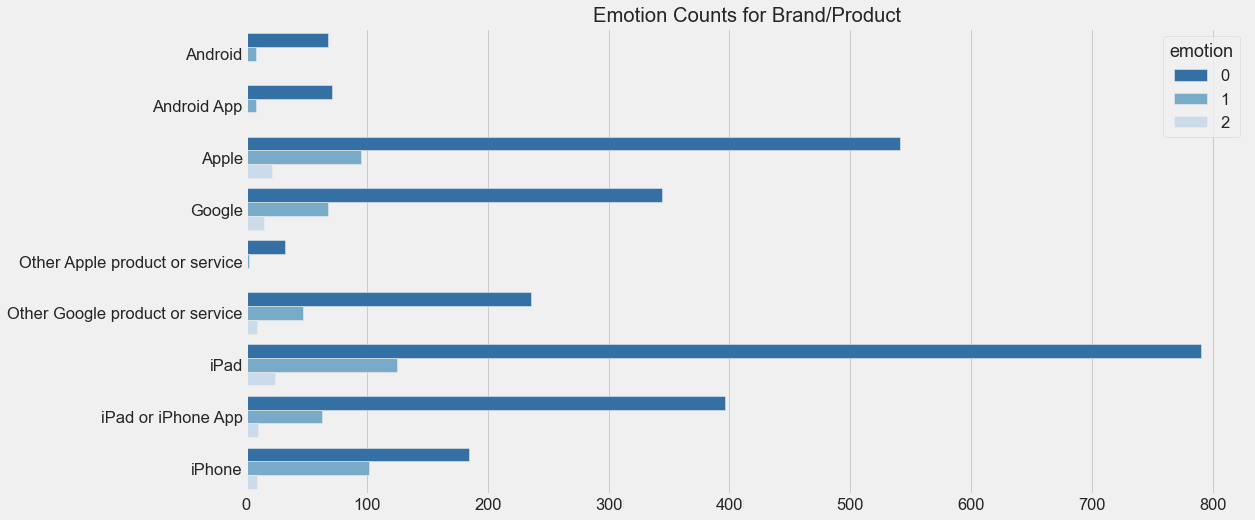

In [63]:
v.brand_emotions(df)

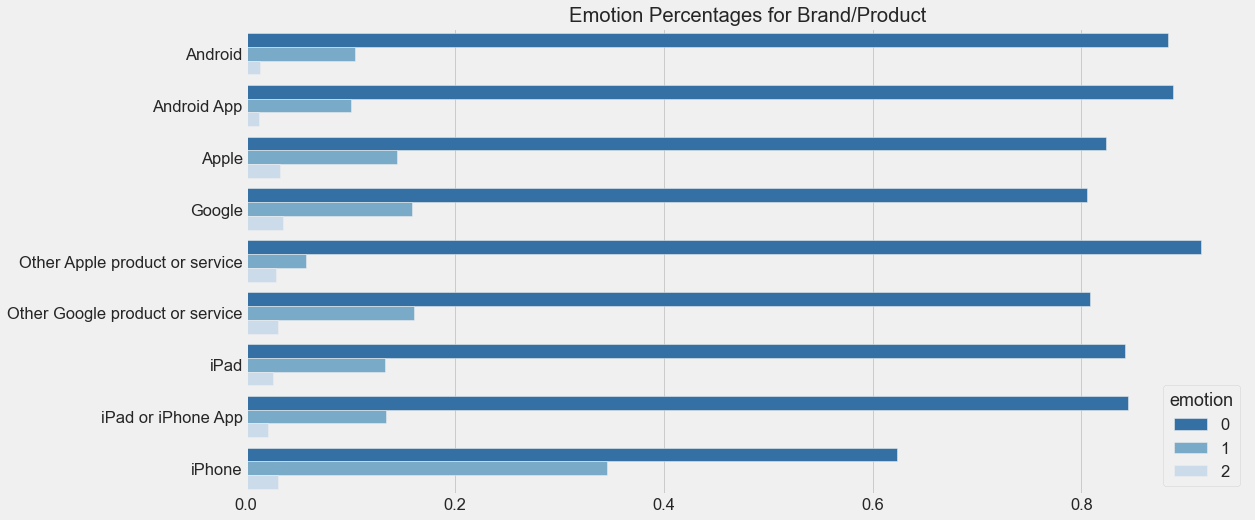

In [64]:
v.brand_emotion_n(df)

## Splitting Emotions for Word Clouds

In [56]:
positive = df[df['emotion']==0]
negative = df[df['emotion']==1]
neutral = df[df['emotion']==2]

In [59]:
pos_words = f.cloud_cleaner_lem(positive.lemmas)
neg_words = f.cloud_cleaner_lem(negative.lemmas)
neu_words = f.cloud_cleaner_lem(neutral.lemmas)

## Word Clouds

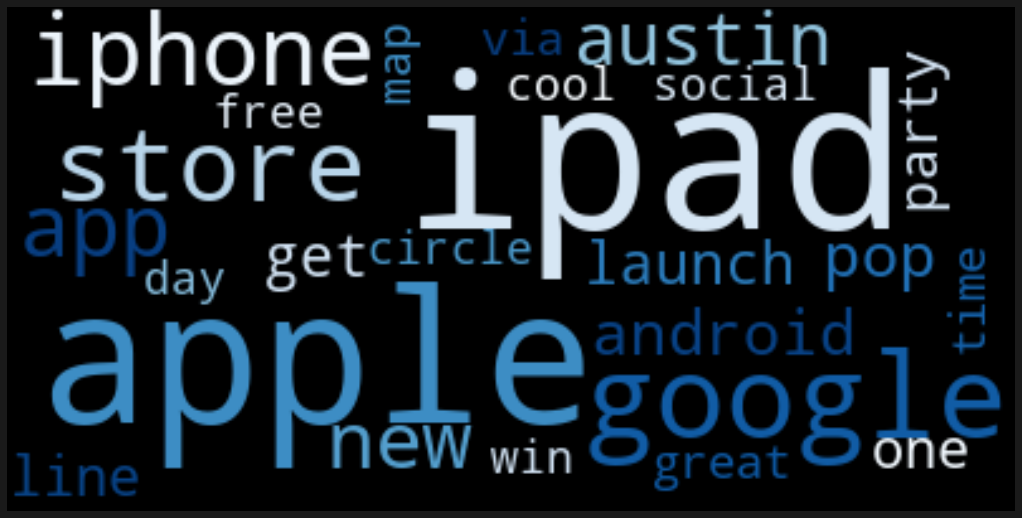

In [81]:
v.word_cloud(pos_words, 25)

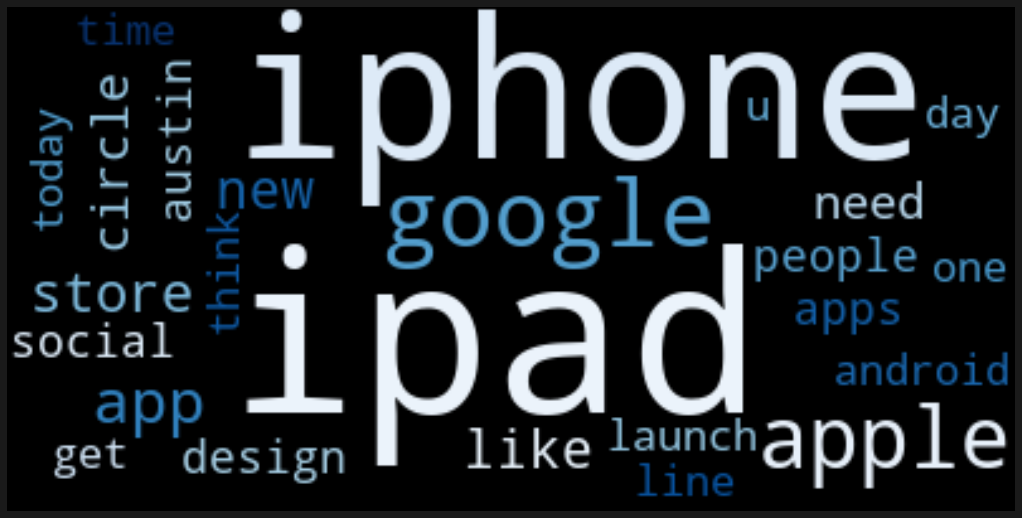

In [82]:
v.word_cloud(neg_words, 25)

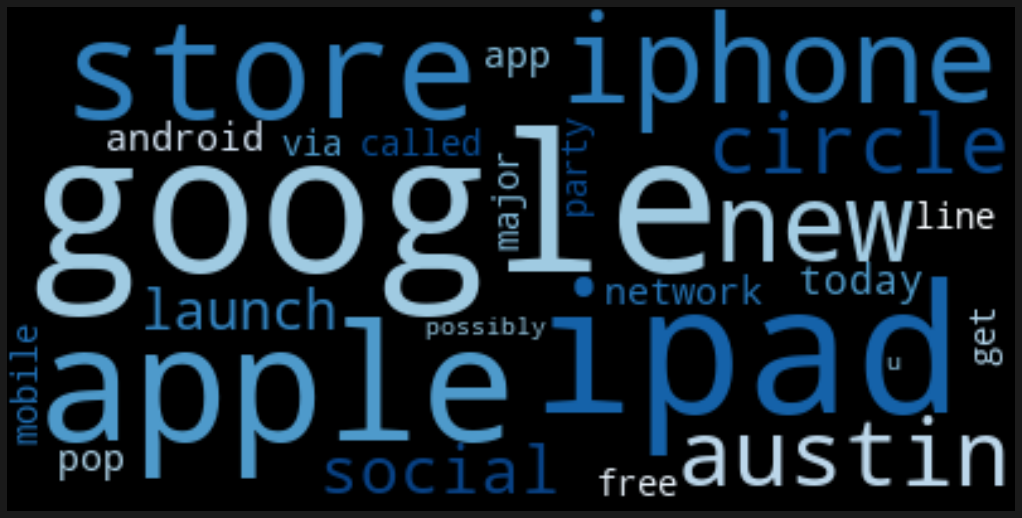

In [83]:
v.word_cloud(neu_words, 25)

#### Baseline Data Frame Info
Based on the EDA, an initial data frame was created with the columns detailed below. 

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5871 entries, 0 to 5870
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   X_lem_aug  5871 non-null   object
 1   y_lem_aug  5871 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.9+ KB


## Modeling

## Importing the Baseline Modeling Data

In [85]:
path = os.path.join(gparent, 'data/processed', 'report_baseline.csv')
df = pd.read_csv(path, encoding='unicode_escape')

#### Baseline Data Frame Info

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X_lem   3537 non-null   object
 1   y_lem   3537 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 55.4+ KB


## Splitting `data` & `target` and Creating Train-Test Split
<font size="4">`emotion` column values = {1: 'negative', 0: 'positive'}</font>

In [87]:
# Creating data & target
X_lem = df.X_lem
y_lem = df.y_lem

In [88]:
# random_state = 2021
X_train, X_test, y_train, y_test = fn.splitter(X_lem,
                                               y_lem)                                                                   

## Preprocessing and Harness Objects
An F1 scoring object and modeling harness were instantiated to cross validate, record, and display the modeling results.

In [89]:
# creating f1 scorer
f1 = f.f1

In [90]:
modeling = c.Harness(f1)

### Baseline Logistic Regression

#### Loading, Fitting & Scoring Model

In [91]:
path = os.path.join(gparent, 'models', 'baseline_model.pkl')

In [92]:
file = open(path, 'rb')
baseline = pickle.load(file)
file.close()

In [93]:
baseline.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


## 5-Fold Cross-Validation: Average F1=0.10

In [94]:
# checking cross val scores
modeling.report(baseline, X_train, y_train, 'Baseline Logistic Regression', 'unbalanced data')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Baseline Logistic Regression has an average F1 of 0.10159590287582469


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


array([0.06741573, 0.10869565, 0.13186813, 0.11111111, 0.08888889])

## Scoring the Model on Test Data

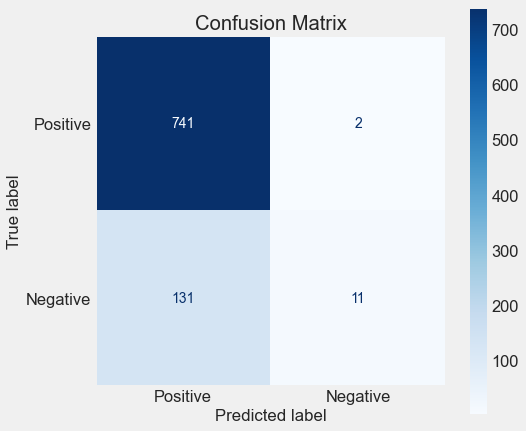

,F1,Recall,Precision
0,0.141935,0.077465,0.846154


In [95]:
f.confusion_report(baseline, X_test, y_test)

### Baseline Scores: F1 = 0.14, Recall = .08, Precision = .85

#### Score Interpretation
Since we want to avoid both false positives and false negatives for this project, a metric of F1 was employed because it is sensitive to both types of error. Also, because F1 is a mix of both precision and recall, the interpretation of the results is more easily described in terms of recall and precision. Overall, the performance of the model very poor.
- From the confusion matrix we see that the baseline model is classifying nearly everything as the majority class.
- A recall score of .08 means that 8% of negative tweets were correctly classified as negative. 
- A precision score of .85 indicates that 85% of tweets classified as negative were truly negative.

## Coefficients of the Top 30 Features 

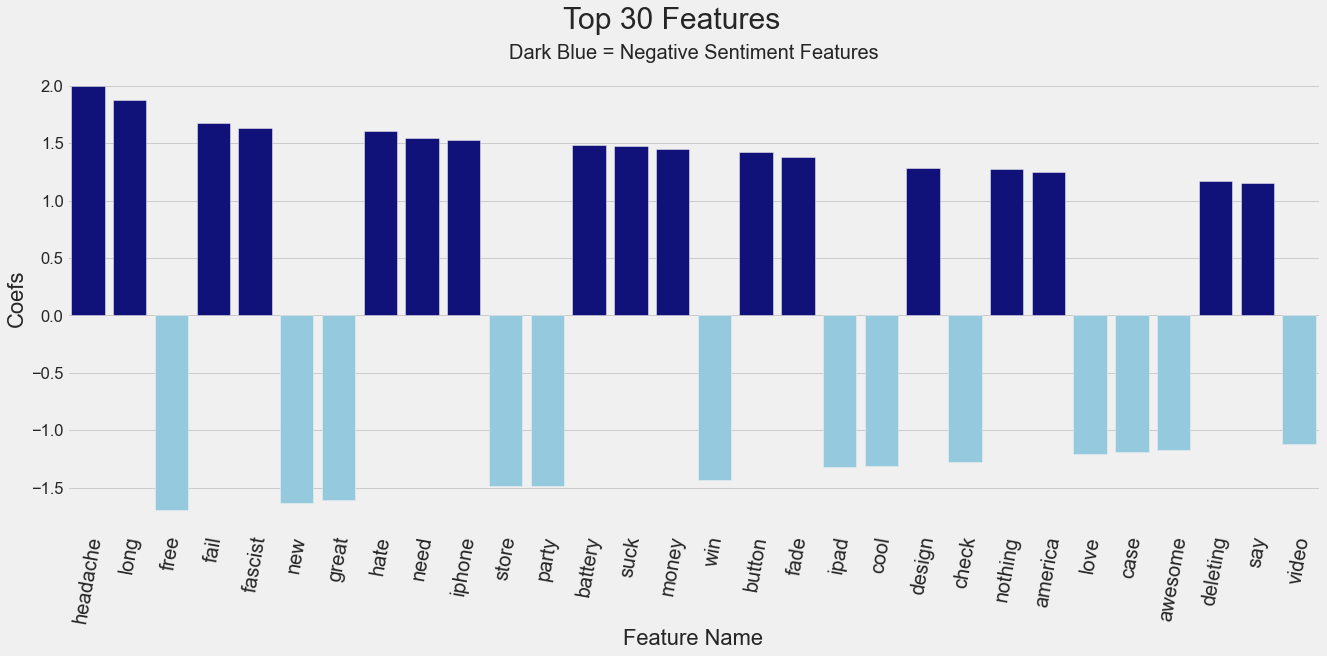

In [96]:
v.base_coefs(baseline)

## Baseline Relative Odds

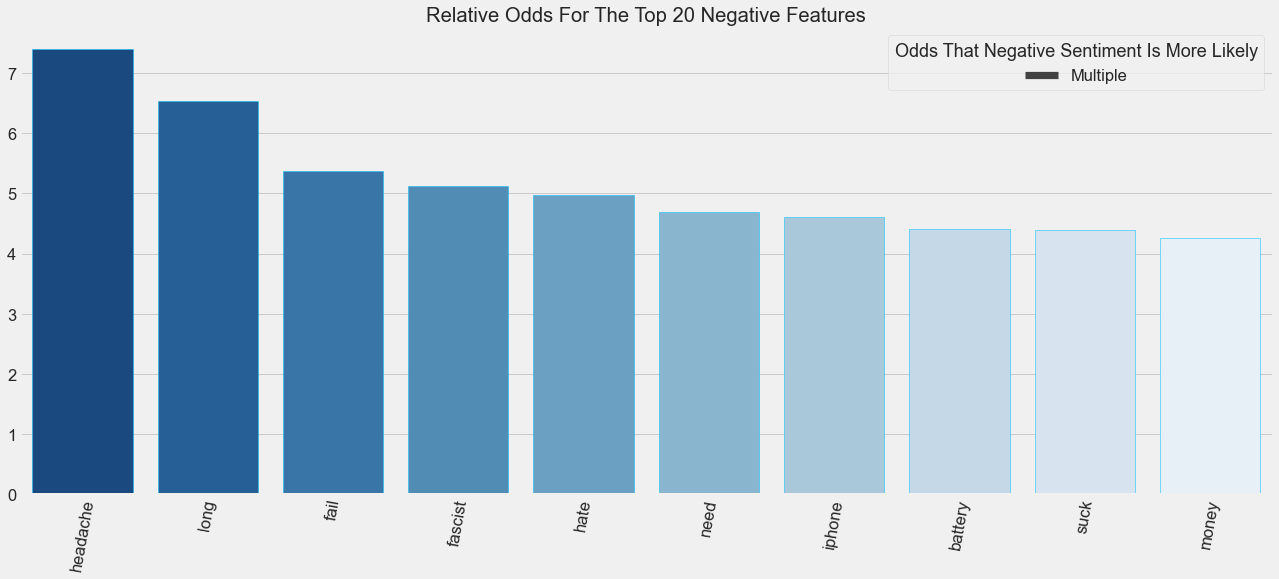

In [97]:
v.base_neg_odds(baseline)

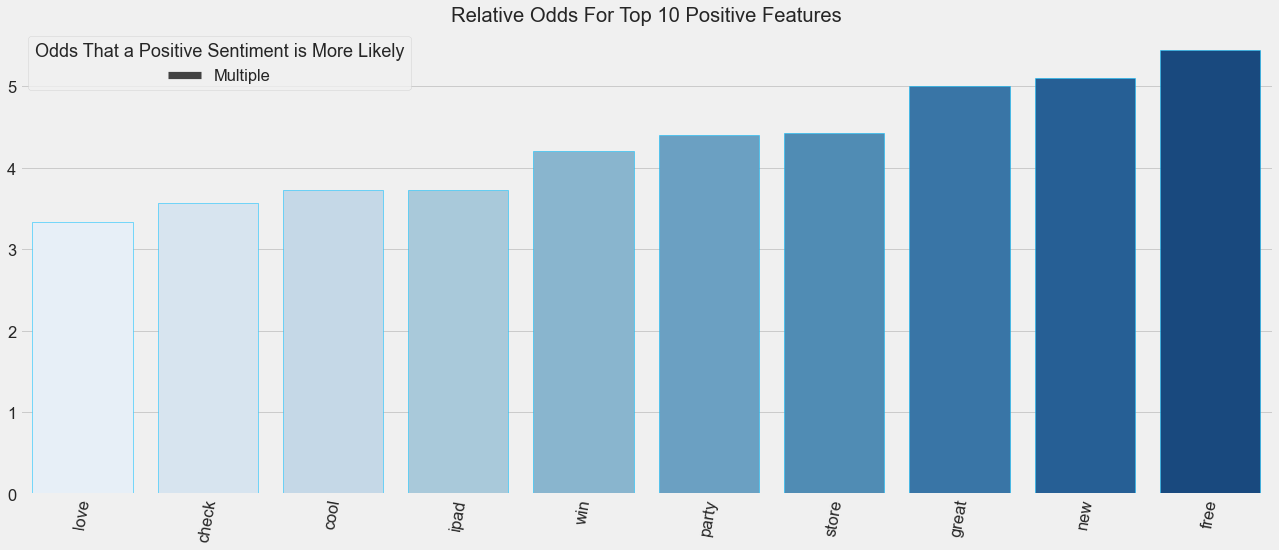

In [98]:
v.base_pos_odds(baseline)

## Interpretation of the Odds
If the assumptions of logistic regression were met by the model, we could numerically quantify the effect of each feature on the model. However, since it is beyond the scope of the project to check that the model meets the underlying assumptions of logistic regression, the most we can say about the features above are their relative importances to the model. A higher bar means more importance of the feature to the model. 

### Data Augementation & Intermediate Models
Fill

## Importing the Augmented EDA Data

In [131]:
path = os.path.join(gparent, 'data/processed', 'augmented_data.csv')
df = pd.read_csv(path, encoding='unicode_escape')

#### Baseline Data Frame Info
Based on the EDA, an initial data frame was created with the columns detailed below. 

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11242 entries, 0 to 11241
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        11242 non-null  int64 
 1   stems          11242 non-null  object
 2   lemmas         11242 non-null  object
 3   tweet          11242 non-null  object
 4   brand_product  3271 non-null   object
 5   hashtags       9236 non-null   object
dtypes: int64(1), object(5)
memory usage: 527.1+ KB


## Class Balance of the Augmented Data

In [133]:
df.emotion.value_counts(normalize=True)

2    0.477762
0    0.264010
1    0.258228
Name: emotion, dtype: float64

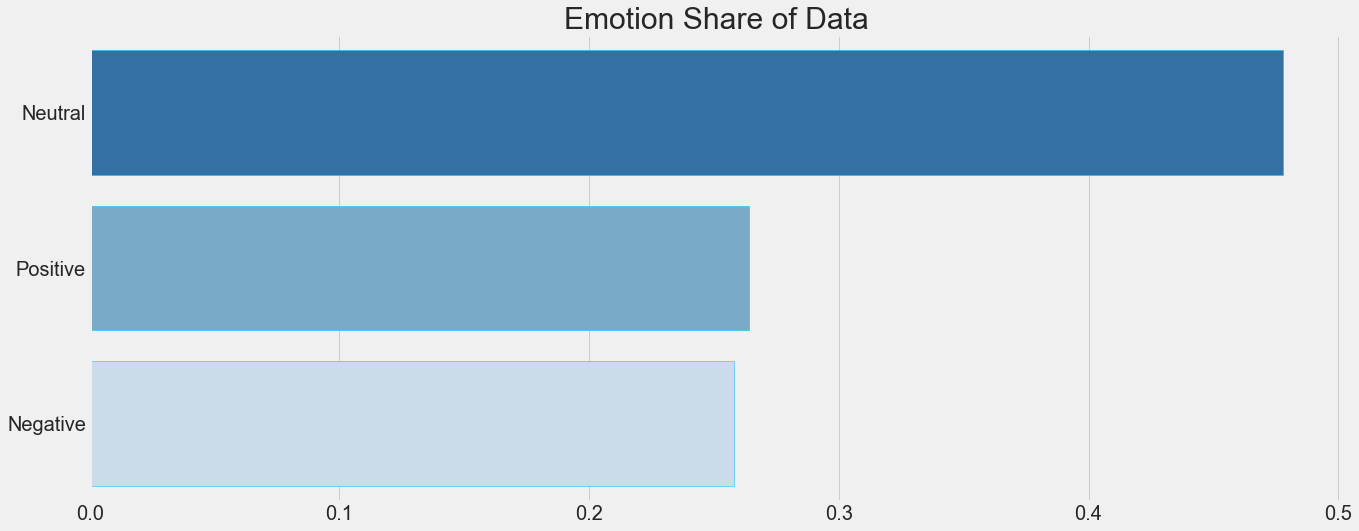

In [135]:
v.emotion_freqs_aug(df)

<font size="4">`Neutral` accounts for 48% of the data.</font>

<font size="4">`Positive`                   accounts for 26% of the data.</font>

<font size="4">`Negative`                   accounts for 26% of the data.</font>

## Splitting Emotions for Word Clouds

In [106]:
positive = df[df['emotion']==0]
negative = df[df['emotion']==1]
neutral = df[df['emotion']==2]

In [107]:
pos_words = f.cloud_cleaner_lem(positive.lemmas)
neg_words = f.cloud_cleaner_lem(negative.lemmas)
neu_words = f.cloud_cleaner_lem(neutral.lemmas)

## Augmented Data Word Clouds

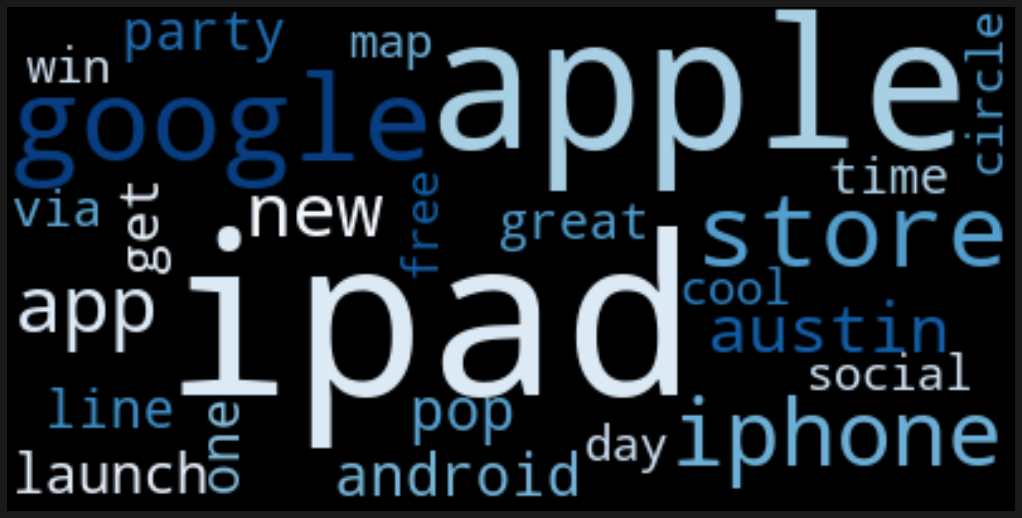

In [108]:
v.word_cloud(pos_words, 25)

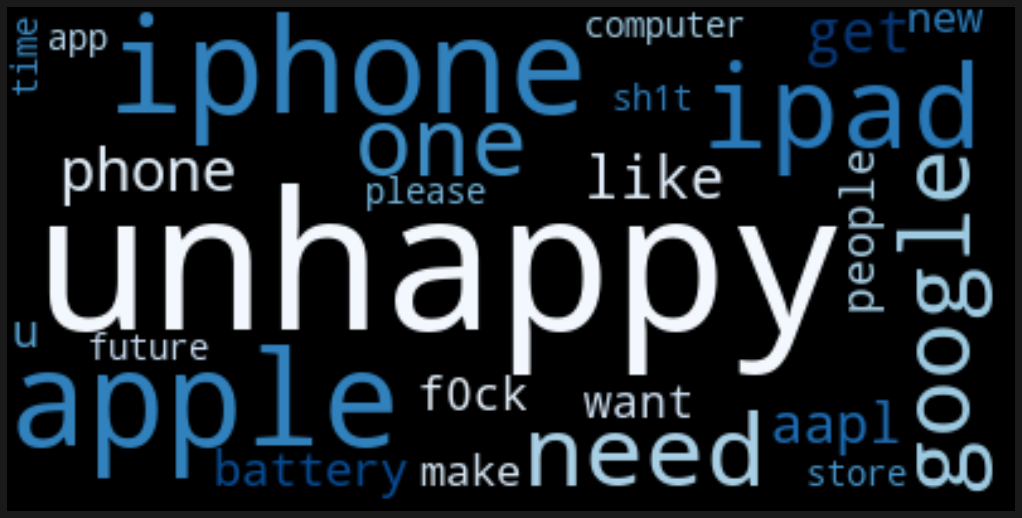

In [109]:
v.word_cloud(neg_words, 25)

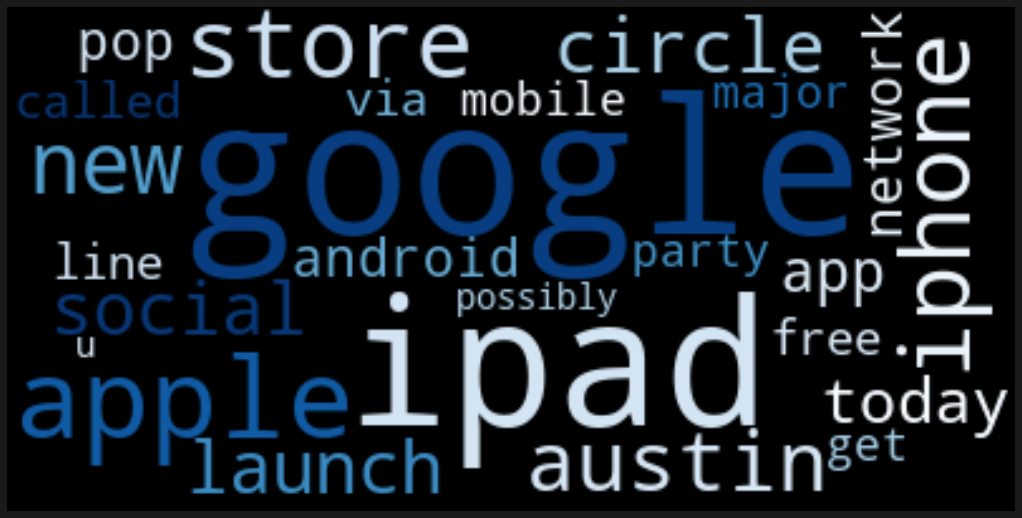

In [110]:
v.word_cloud(neu_words, 25)

In [111]:
path = os.path.join(gparent, 'data/processed', 'report_aug.csv')
df = pd.read_csv(path, encoding='unicode_escape')

## Splitting `data` & `target` and Creating Train-Test Split
<font size="4">`emotion` column values = {1: 'negative', 0: 'positive'}</font>

In [112]:
# Creating data & target
X_lem_aug = df.X_lem_aug
y_lem_aug = df.y_lem_aug

In [113]:
X_aug_train, X_aug_test, y_aug_train, y_aug_test = fn.splitter(X_lem_aug,
                                                               y_lem_aug)            

## Baseline Classifier on Augmented Data

In [114]:
baseline.fit(X_aug_train, y_aug_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

## 5-Fold Cross-Validation: Average F1=.89

In [115]:
modeling.report(baseline, X_aug_train, y_aug_train, 'baseline_aug', 'augmented data')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


baseline_aug has an average F1 of 0.8897502471347287


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


array([0.88264059, 0.8856799 , 0.90669856, 0.87651332, 0.89721886])

## Scoring the Model on Test Data

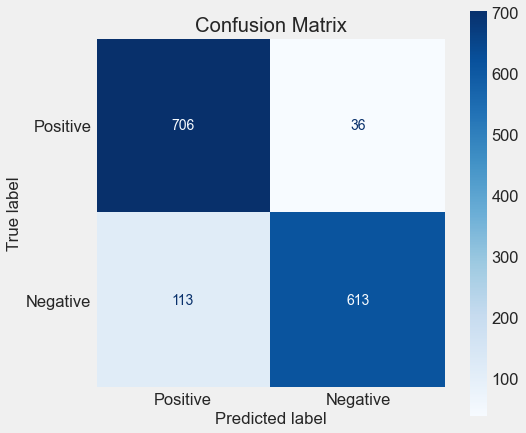

,F1,Recall,Precision
0,0.891636,0.844353,0.94453


In [116]:
fn.confusion_report(baseline, X_aug_test, y_aug_test)

## Baseline Model with Augmented Data Metrics:
<font size="4">F1=0.89, Recall=0.84, Precision=0.94</font>

#### Score Interpretation
From the confusion matrix we see that the baseline model still has a little trouble classifying negatives relative to positives, but the overall performance is acceptable.

- The performance of the baseline model has been greatly improved by the addition of new minority class data. 
- A recall score of .84 means that 84% of negative tweets were correctly classified as negative. 
- A precision score of .94 indicates that 94% of tweets classified as negative were truly negative.

## Augmented Baseline Coefficients & Odds

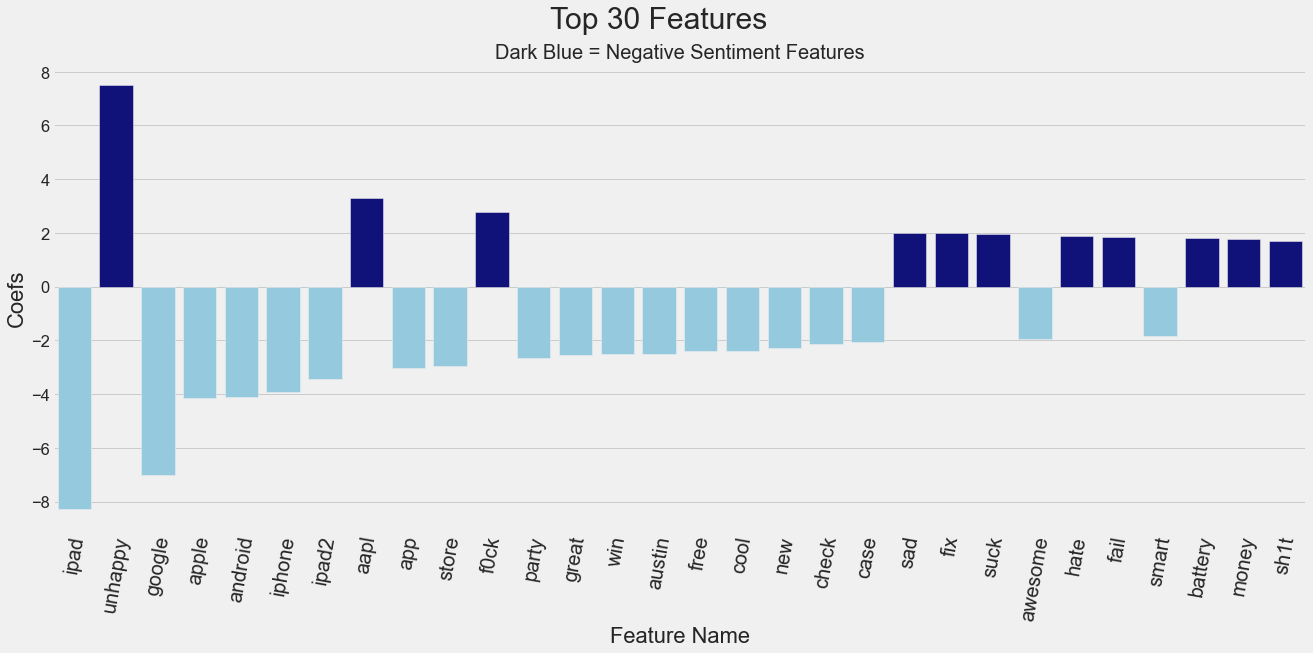

In [117]:
v.base_coefs(baseline)

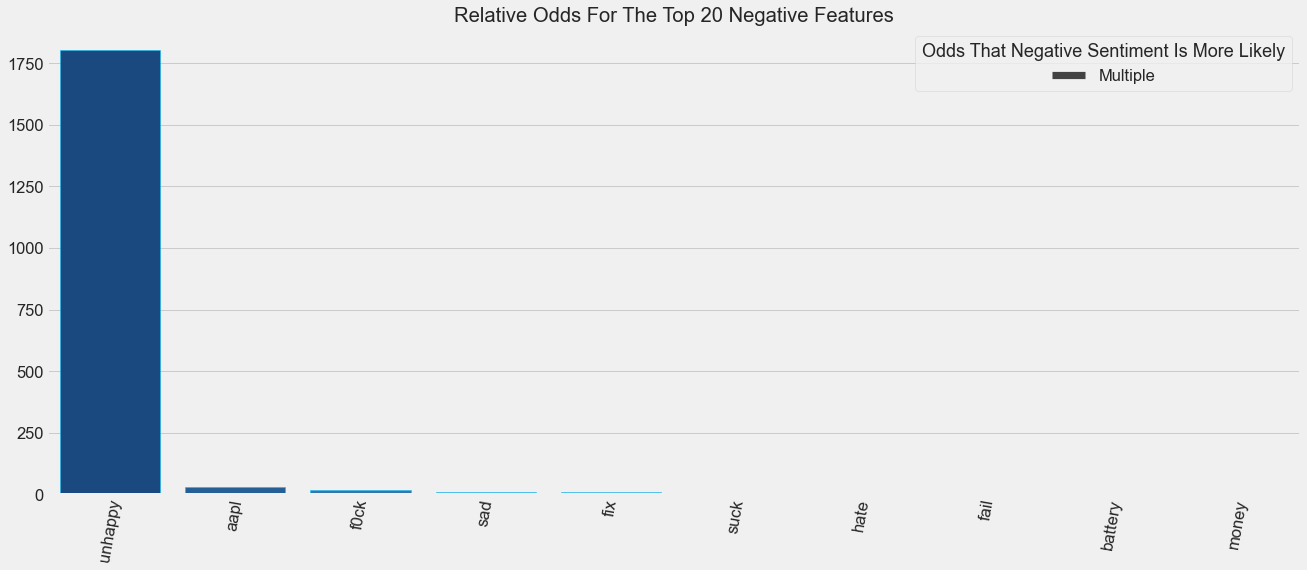

In [118]:
v.base_neg_odds(baseline)

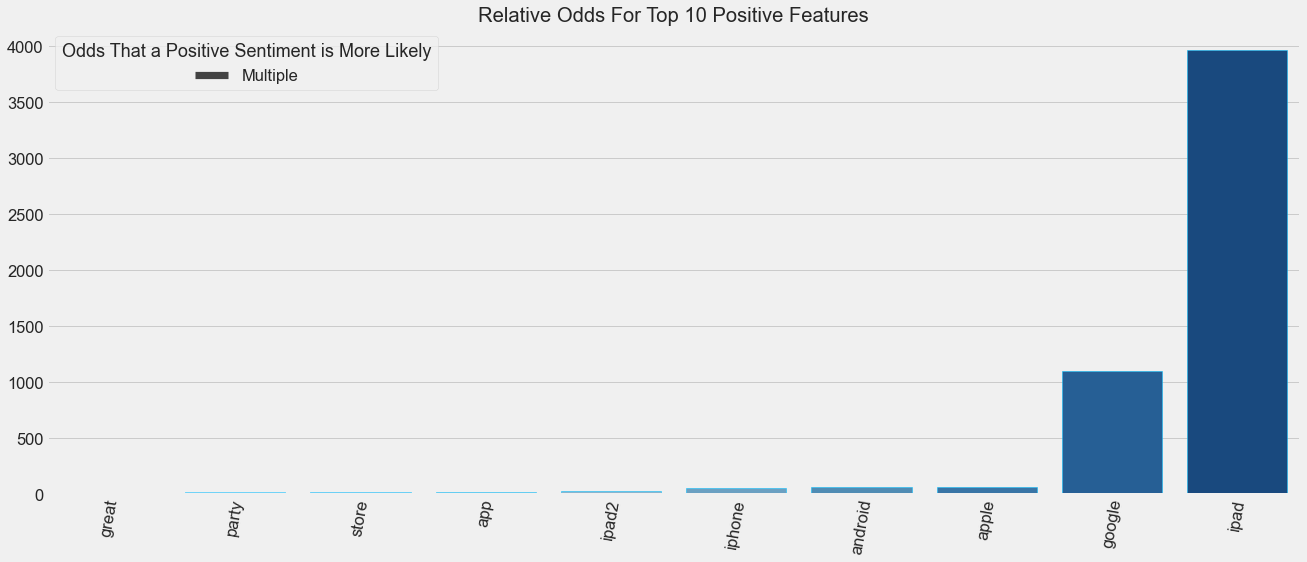

In [79]:
v.base_pos_odds(baseline)

## Interpretation of the Odds
If the assumptions of logistic regression were met by the model, we could numerically quantify the effect of each feature on the model. However, since it is beyond the scope of the project to check that the model meets the underlying assumptions of logistic regression, the most we can say about the features above are their relative importances to the model. A higher bar means more importance of the feature to the model. 

## MVP Model: 
<font size="4">Random Forest CLF Tuned on Augmented Lemmatized Data</font>

#### Loading & Fitting Model

In [140]:
path = os.path.join(gparent, 'models', 'MVP_model.pkl')

file = open(path, 'rb')
tuned_rf_aug = pickle.load(file)
file.close()

tuned_rf_aug.fit(X_aug_train, y_aug_train)

## 5-Fold Cross-Validation: Average F1=.89

In [143]:
modeling.report(baseline, X_aug_train, y_aug_train, 'tuned_rf_aug', 'MVP model')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


tuned_rf_aug has an average F1 of 0.8897502471347287


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


array([0.88264059, 0.8856799 , 0.90669856, 0.87651332, 0.89721886])

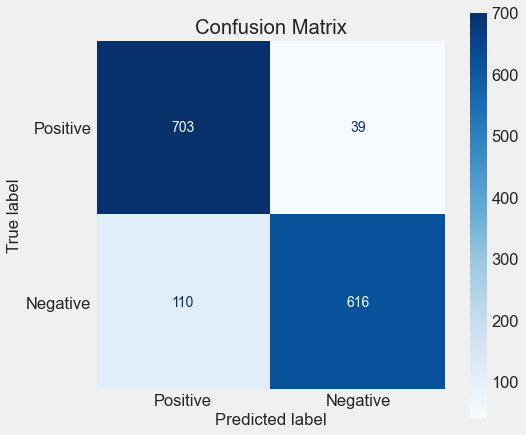

,F1,Recall,Precision
0,0.892107,0.848485,0.940458


In [142]:
fn.confusion_report(tuned_rf_aug, X_aug_test, y_aug_test)

## MVP Model Metrics:
<font size="4">Metrics: F1=0.89, Recall=0.85, Precision=0.94</font>

#### Score Interpretation
From the confusion matrix we see that the MVP model still has a little trouble classifying negatives relative to positives, but the overall performance is acceptable.

- The performance of the baseline model has been greatly improved by the addition of new minority class data. 
- A recall score of .85 means that 85% of negative tweets were correctly classified as negative. 
- A precision score of .94 indicates that 94% of tweets classified as negative were truly negative.

## MVP Model Feature Importances

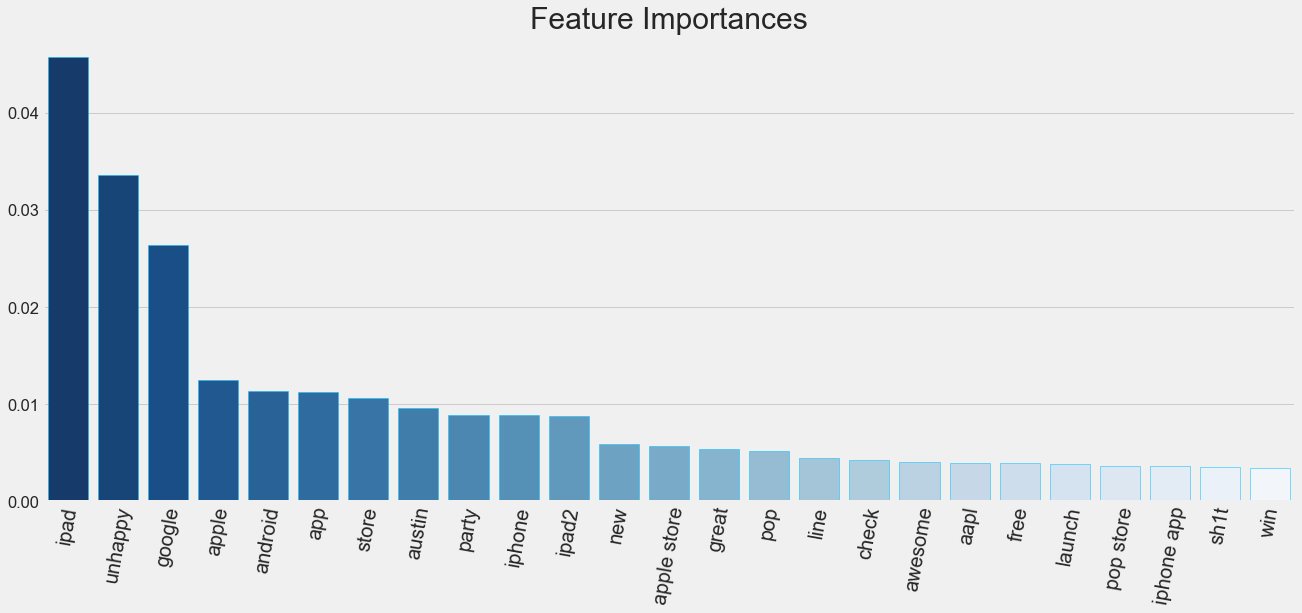

In [225]:
vz.feature_plot(tuned_rf_aug)